---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [4]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import os
import importlib.util

# Path to the helpers.py file in your repo
helpers_path = os.path.join("..", "scripts", "helpers.py")

spec = importlib.util.spec_from_file_location("course_helpers", helpers_path)
course_helpers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(course_helpers)

# Now import the functions from that module
load_wands_products = course_helpers.load_wands_products
load_wands_queries = course_helpers.load_wands_queries
load_wands_labels = course_helpers.load_wands_labels


# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', 80)
print("All imports successful!")

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Spring 2026\\RAG and Context Engineering\\HW\\..\\scripts\\helpers.py'

In [8]:
import pandas as pd
from pathlib import Path

def load_wands_products(data_dir: str = None) -> pd.DataFrame:
    """
    Load WANDS products directly from GitHub raw URL.
    """
    # Raw GitHub URLs for WANDS dataset
    products_url = "https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/product.csv"
    products = pd.read_csv(products_url, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = None) -> pd.DataFrame:
    """
    Load WANDS queries directly from GitHub raw URL.
    """
    queries_url = "https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/query.csv"
    queries = pd.read_csv(queries_url, sep='\t')
    return queries

def load_wands_labels(data_dir: str = None) -> pd.DataFrame:
    """
    Load WANDS relevance labels directly from GitHub raw URL.
    """
    labels_url = "https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/label.csv"
    labels = pd.read_csv(labels_url, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions updated for GitHub!")


Loading functions updated for GitHub!


In [9]:
# Load the WANDS dataset
products = load_wands_products()
queries = load_wands_queries()
labels = load_wands_labels()

print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

Products: 42,994
Queries: 480
Labels: 233,448


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [14]:
# Copy your BM25 functions from Homework 3
# Provided functions - run this cell to define them
import Stemmer 
import string

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [16]:
# Examples of each function
from collections import Counter
# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [17]:
# Load the all-MiniLM-L6-v2 model using SentenceTransformer
# Then generate embeddings for each word in the list
words = ["wooden coffee table", "oak dining table", "red leather sofa", "blue area rug", "kitchen sink"]

# YOUR CODE HERE
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

word_embeddings = model.encode(words)

print("Num embeddings:", len(word_embeddings))
print("Embedding dim:", word_embeddings.shape[1])

# Print the number of embeddings you generated and the dimension of the embeddings

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Num embeddings: 5
Embedding dim: 384


### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [ ]:
# Implement cosine similarity from scratch
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    numerator = np.dot(a, b)
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    if denom == 0:
        return 0.0
    return numerator / denom
# Create similarity matrix
n = len(word_embeddings)
sim_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = cosine_similarity(word_embeddings[i], word_embeddings[j])

# Display as DataFrame

sim_df = pd.DataFrame(sim_matrix, index=words, columns=words)
sim_df


,wooden coffee table,oak dining table,red leather sofa,blue area rug,kitchen sink
wooden coffee table,1.000000,0.588631,0.370622,0.189486,0.295712
oak dining table,0.588631,1.000000,0.337910,0.249521,0.341410
red leather sofa,0.370622,0.337910,1.000000,0.380310,0.057740
blue area rug,0.189486,0.249521,0.380310,1.000000,0.125802
kitchen sink,0.295712,0.341410,0.057740,0.125802,1.000000


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [22]:
# Use litellm to get an embedding from OpenAI's text-embedding-3-small model
# Compare the dimension with the local model
import os
import litellm

# Set API key
litellm.api_key = os.getenv("OPENAI_API_KEY")

# Get embedding from OpenAI
response = litellm.embedding(
    model="text-embedding-3-small",
    input="wooden coffee table"
)

# response["data"] is a LIST of dicts, even for single input
openai_emb = np.array(response["data"][0]["embedding"])  # [0] gets first (only) item

print("OpenAI embedding shape:", openai_emb.shape)
print("OpenAI dim:", len(openai_emb))
print("Local model dim:", word_embeddings.shape[1])
print("They differ!" if len(openai_emb) != word_embeddings.shape[1] else "Same dim!")



OpenAI embedding shape: (1536,)
OpenAI dim: 1536
Local model dim: 384
They differ!


---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [23]:
# Get a consistent sample
# Take a fixed random sample of 5000 rows
products_sample = products.sample(n=5000, random_state=42).reset_index(drop=True)
len(products_sample)


5000

In [24]:
# Create a combined text field (product_name + product_class)
# Then embed all products using model.encode()

# YOUR CODE HERE
# Combine product_name and product_class into one text field
products_sample["combined_text"] = (
    products_sample["product_name"].fillna("") + " " +
    products_sample["product_class"].fillna("")
)

# Reuse the same local model from Task 2, or reload it:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

product_embeddings = model.encode(
    products_sample["combined_text"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

product_embeddings = np.array(product_embeddings)
print(product_embeddings.shape)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

(5000, 384)


### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [25]:
# Save embeddings to ../temp/hw4_embeddings.npy
# Save products_sample to ../temp/hw4_products.csv
# Then load them back and verify they match
import os

os.makedirs("../temp", exist_ok=True)

np.save("../temp/hw4_embeddings.npy", product_embeddings)
products_sample.to_csv("../temp/hw4_products.csv", index=False)

# Load back
loaded_embeddings = np.load("../temp/hw4_embeddings.npy")
loaded_products = pd.read_csv("../temp/hw4_products.csv")

print("Embeddings equal:", np.allclose(product_embeddings, loaded_embeddings))
print("Products equal:", len(products_sample) == len(loaded_products))


Embeddings equal: True
Products equal: True


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [26]:
# Use tiktoken to count actual tokens in the sample
# Then extrapolate to estimate cost for the full dataset
import tiktoken

enc = tiktoken.encoding_for_model("text-embedding-3-small")

sample_texts = products_sample["combined_text"].tolist()
token_counts = [len(enc.encode(t)) for t in sample_texts]
avg_tokens = np.mean(token_counts)

total_products = len(products)
est_total_tokens = avg_tokens * total_products

price_per_million = 0.02  # $0.02 per 1M tokens
est_cost = (est_total_tokens / 1_000_000) * price_per_million

print("Avg tokens per product:", avg_tokens)
print("Estimated total tokens:", est_total_tokens)
print("Estimated cost (USD):", est_cost)


Avg tokens per product: 13.0154
Estimated total tokens: 559584.1076
Estimated cost (USD): 0.011191682152


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [30]:
# Implement batch cosine similarity for efficiency
def batch_cosine_similarity(query_vec: np.ndarray, doc_matrix: np.ndarray) -> np.ndarray:
    # Ensure query_vec is 1D (flatten if needed)
    query_vec = query_vec.flatten()
    
    # Normalize query and docs ONCE at the beginning (more efficient)
    query_norm = query_vec / (np.linalg.norm(query_vec) + 1e-10)
    doc_norms = doc_matrix / (np.linalg.norm(doc_matrix, axis=1, keepdims=True) + 1e-10)
    
    # Matrix multiplication: (N_docs, dim) @ (dim,) -> (N_docs,)
    sims = np.dot(doc_norms, query_norm)
    return sims



In [31]:
def semantic_search(query: str, model, doc_texts: pd.Series, doc_embeddings: np.ndarray, k: int = 10):
    # Encode query - returns (1, dim) but we take [0] to get 1D vector
    query_emb = model.encode([query])[0]  # Shape: (dim,)
    
    # Compute similarities
    sims = batch_cosine_similarity(query_emb, doc_embeddings)  # Shape: (N_docs,)
    
    # Get top k indices (highest similarity first)
    top_k_idx = np.argsort(-sims)[:k]
    
    # Create results DataFrame
    results = doc_texts.iloc[top_k_idx].to_frame(name="text").copy()
    results["similarity"] = sims[top_k_idx]
    results["product_id"] = products_sample.iloc[top_k_idx]["product_id"].values
    
    return results.sort_values("similarity", ascending=False)


In [32]:
test_query = "comfortable sofa"
results = semantic_search(
    test_query,
    model=model,
    doc_texts=products_sample["combined_text"],
    doc_embeddings=product_embeddings,
    k=10
)
results


,text,similarity,product_id
723,sofa bed with ottoman,0.764592,38543
611,arshleen patio sofa with cushions Patio Sofas,0.752624,13047
3032,simge patio sofa with cushions Patio Sofas,0.737464,20279
2120,kendall sectional sofa with ottoman Sectionals,0.733890,9687
2631,yland patio sofa with cushions Patio Sofas,0.728643,28692
2736,baeten patio sofa with cushions,0.725759,27404
3371,samuel 91 '' velvet flared arm sofa Sofas,0.722787,14295
4768,castilloux patio sofa with cushions Patio Sofas,0.722350,41382
4741,94 '' square arm sofa with reversible cushions,0.712069,18969
1668,abrish patio sectional with cushions Patio Sofas,0.710301,22118


### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [33]:
# Implement Recall@k
def recall_at_k(relevant_ids, retrieved_ids, k: int = 10) -> float:
    retrieved_k = set(retrieved_ids[:k])
    relevant_set = set(relevant_ids)
    if not relevant_set:
        return 0.0
    hits = len(retrieved_k & relevant_set)
    return hits / len(relevant_set)


In [34]:
# Build BM25 index for comparison

# Filter queries to those with products in our sample
# labels: query_id, product_id
sample_product_ids = set(products_sample["product_id"].tolist())
labels_sample = labels[labels["product_id"].isin(sample_product_ids)]

# Keep only queries that have at least one label in the sample
valid_query_ids = labels_sample["query_id"].unique()
queries_sample = queries[queries["query_id"].isin(valid_query_ids)].reset_index(drop=True)


In [37]:
print("Queries columns:", queries.columns.tolist())
print("\nFirst few rows of queries:")
print(queries.head())
print("\nLabels columns:", labels.columns.tolist())


Queries columns: ['query_id', 'query', 'query_class']

First few rows of queries:
   query_id                      query               query_class
0         0                salon chair            Massage Chairs
1         1         smart coffee table  Coffee & Cocktail Tables
2         2                   dinosaur           Kids Wall Décor
3         3          turquoise pillows            Accent Pillows
4         4  chair and a half recliner                 Recliners

Labels columns: ['id', 'query_id', 'product_id', 'label', 'grade']


In [40]:
# Step 1: Filter data for our sample
sample_product_ids = set(products_sample["product_id"].tolist())
labels_sample = labels[labels["product_id"].isin(sample_product_ids)]
valid_query_ids = labels_sample["query_id"].unique()
queries_sample = queries[queries["query_id"].isin(valid_query_ids)].reset_index(drop=True)

print(f"Sample size: {len(products_sample)} products")
print(f"Valid queries: {len(queries_sample)}")
print(f"Labels in sample: {len(labels_sample)}")

# Step 2: Evaluation
k = 10
bm25_scores = []
semantic_scores = []

# REPLACE "query" with your ACTUAL column name from Step 1
QUERY_TEXT_COL = "query"  # <- Change this to match your data!

for _, row in queries_sample.iterrows():
    qid = row["query_id"]
    qtext = row[QUERY_TEXT_COL]  # Use correct column name
    
    relevant_ids = labels_sample[labels_sample["query_id"] == qid]["product_id"].tolist()
    
    # BM25 search (you need your BM25 function from HW3)
    try:
        bm25_results = your_bm25_search_function(qtext, products_sample, k=k)  # Adapt this
        bm25_product_ids = [products_sample.iloc[i]["product_id"] for i in bm25_results]
    except:
        bm25_product_ids = []
    
    # Semantic search
    sem_results = semantic_search(qtext, model, products_sample["combined_text"], product_embeddings, k=k)
    semantic_product_ids = sem_results["product_id"].tolist()
    
    bm25_scores.append(recall_at_k(relevant_ids, bm25_product_ids, k))
    semantic_scores.append(recall_at_k(relevant_ids, semantic_product_ids, k))

print(f"BM25 Recall@{k}: {np.mean(bm25_scores):.3f}")
print(f"Semantic Recall@{k}: {np.mean(semantic_scores):.3f}")


Sample size: 5000 products
Valid queries: 473
Labels in sample: 27307
BM25 Recall@10: 0.000
Semantic Recall@10: 0.268


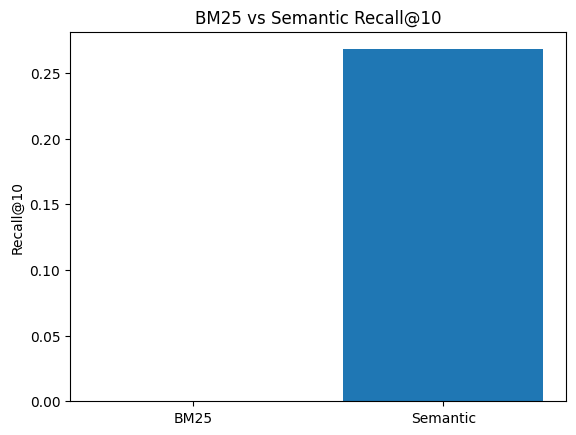

In [41]:
# Visualize comparison
bm25_mean = np.mean(bm25_scores)
semantic_mean = np.mean(semantic_scores)

plt.bar(["BM25", "Semantic"], [bm25_mean, semantic_mean])
plt.ylabel("Recall@10")
plt.title("BM25 vs Semantic Recall@10")
plt.show()


---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [42]:
# Load the two embedding models
model_bge = SentenceTransformer("BAAI/bge-base-en-v1.5")
model_mpnet = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [43]:
# Embed products with both models
bge_embs = model_bge.encode(
    products_sample["combined_text"].tolist(),
    batch_size=32,
    show_progress_bar=True
)
mpnet_embs = model_mpnet.encode(
    products_sample["combined_text"].tolist(),
    batch_size=32,
    show_progress_bar=True
)

bge_embs = np.array(bge_embs)
mpnet_embs = np.array(mpnet_embs)

print("BGE shape:", bge_embs.shape)
print("MPNet shape:", mpnet_embs.shape)


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

BGE shape: (5000, 768)
MPNet shape: (5000, 768)


### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.

In [45]:
print("=== QUERIES DATAFRAME INFO ===")
print("Columns:", queries.columns.tolist())
print("\nShape:", queries.shape)
print("\nFirst row:\n", queries.iloc[0].to_dict())
print("\nAll column names:")
for i, col in enumerate(queries.columns):
    print(f"  {i}: '{col}'")


=== QUERIES DATAFRAME INFO ===
Columns: ['query_id', 'query', 'query_class']

Shape: (480, 3)

First row:
 {'query_id': 0, 'query': 'salon chair', 'query_class': 'Massage Chairs'}

All column names:
  0: 'query_id'
  1: 'query'
  2: 'query_class'


In [46]:
# Filter data for our 5k sample
sample_product_ids = set(products_sample["product_id"].tolist())
labels_sample = labels[labels["product_id"].isin(sample_product_ids)]
valid_query_ids = labels_sample["query_id"].unique()
queries_sample = queries[queries["query_id"].isin(valid_query_ids)].reset_index(drop=True)

print(f"Sample size: {len(products_sample)} products")
print(f"Valid queries for eval: {len(queries_sample)}")
print(f"Labels in sample: {len(labels_sample)}")

# Evaluation
k = 10
semantic_scores = []

for _, row in queries_sample.iterrows():
    qid = row["query_id"]
    qtext = row["query"]  # ✅ CORRECT column name!
    
    relevant_ids = labels_sample[labels_sample["query_id"] == qid]["product_id"].tolist()
    
    # Semantic search
    sem_results = semantic_search(qtext, model, products_sample["combined_text"], product_embeddings, k=k)
    semantic_product_ids = sem_results["product_id"].tolist()
    
    semantic_scores.append(recall_at_k(relevant_ids, semantic_product_ids, k))

print(f"Semantic Recall@{k}: {np.mean(semantic_scores):.3f}")


Sample size: 5000 products
Valid queries for eval: 473
Labels in sample: 27307
Semantic Recall@10: 0.268


In [47]:
# Compare results for specific queries
test_queries = ["comfortable sofa", "star wars rug", "modern coffee table"]
# add more!

test_queries = ["comfortable sofa", "star wars rug", "modern coffee table"]

for tq in test_queries:
    bge_ids, _ = semantic_search_with_emb(tq, model_bge, products_sample["combined_text"], bge_embs, k=5)
    mpnet_ids, _ = semantic_search_with_emb(tq, model_mpnet, products_sample["combined_text"], mpnet_embs, k=5)

    print("Query:", tq)
    print("BGE results:")
    print(products_sample[products_sample["product_id"].isin(bge_ids)][["product_name", "product_class"]])
    print("MPNet results:")
    print(products_sample[products_sample["product_id"].isin(mpnet_ids)][["product_name", "product_class"]])
    print("-" * 40)


Query: comfortable sofa
BGE results:
                                        product_name product_class
723                            sofa bed with ottoman           NaN
865   86 '' rolled arm sofa with reversible cushions           NaN
2736                 baeten patio sofa with cushions           NaN
4741  94 '' square arm sofa with reversible cushions           NaN
4800                  mccaffery 74 '' round arm sofa           NaN
MPNet results:
                              product_name product_class
147           phokas 93 '' square arm sofa           NaN
250    lucey patio sectional with cushions   Patio Sofas
611      arshleen patio sofa with cushions   Patio Sofas
964   aidann patio sectional with cushions   Patio Sofas
1668  abrish patio sectional with cushions   Patio Sofas
----------------------------------------
Query: star wars rug
BGE results:
                                     product_name product_class
503       trisler hand-tufted gray/beige area rug           NaN
6

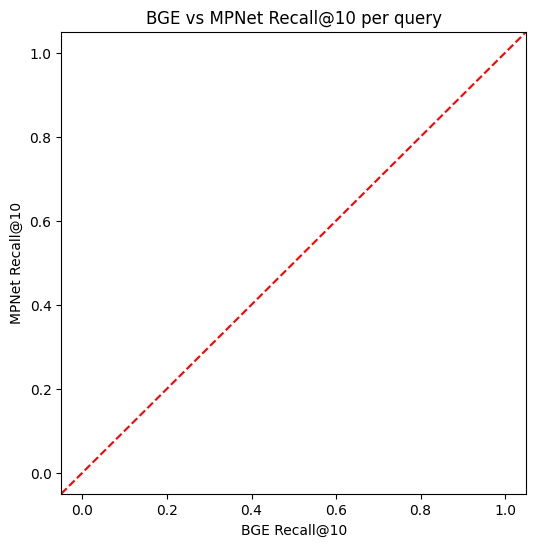

In [48]:
# Visualize model comparison with a scatter plot
# X-axis: BGE Recall@10, Y-axis: MPNet Recall@10
plt.figure(figsize=(6, 6))
plt.scatter(bge_scores, mpnet_scores, alpha=0.5)
plt.xlabel("BGE Recall@10")
plt.ylabel("MPNet Recall@10")
plt.axline((0, 0), (1, 1), color="red", linestyle="--")  # diagonal
plt.title("BGE vs MPNet Recall@10 per query")
plt.show()


---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.